In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/Kvasir/kvasir-dataset-v2.zip -d /content/drive/MyDrive/Dataset/Kvasir

In [ ]:
!pip install timm
!pip install lightning
!pip install wandb

In [4]:
import timm
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Dataset, Subset
import pytorch_lightning as pl
import torchmetrics
from torchmetrics import Accuracy, F1Score, ConfusionMatrix
from torchmetrics.classification import MulticlassAccuracy

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
import wandb

In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
len(os.listdir('/content/drive/MyDrive/Dataset/Kvasir/kvasir-dataset-v2/dyed-lifted-polyps'))

1000

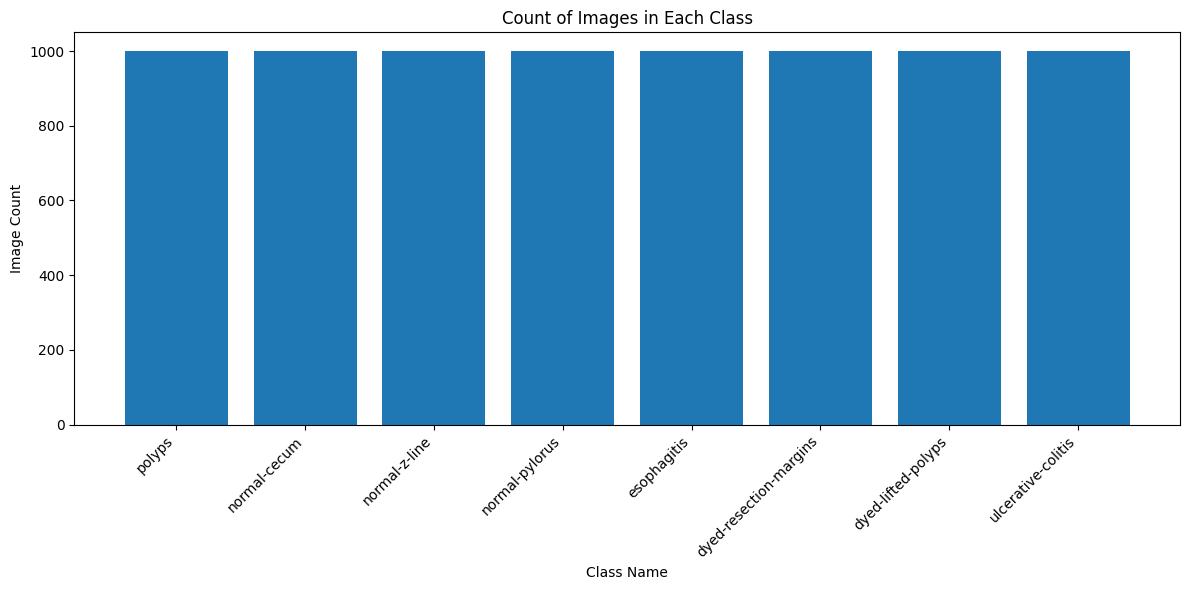

In [7]:
# for plotting the count of each class in the folder
dataset_folder = '/content/drive/MyDrive/Dataset/Kvasir/kvasir-dataset-v2'
class_counts = {}

# Iterate through each class folder and count the images
for class_name in os.listdir(dataset_folder):
    if os.path.isdir(os.path.join(dataset_folder, class_name)):
        class_count = len(os.listdir(os.path.join(dataset_folder, class_name)))
        class_counts[class_name] = class_count

# Extract class names and counts
class_names = list(class_counts.keys())
class_counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class Name')
plt.ylabel('Image Count')
plt.title('Count of Images in Each Class')
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [8]:
class_names

['polyps',
 'normal-cecum',
 'normal-z-line',
 'normal-pylorus',
 'esophagitis',
 'dyed-resection-margins',
 'dyed-lifted-polyps',
 'ulcerative-colitis']

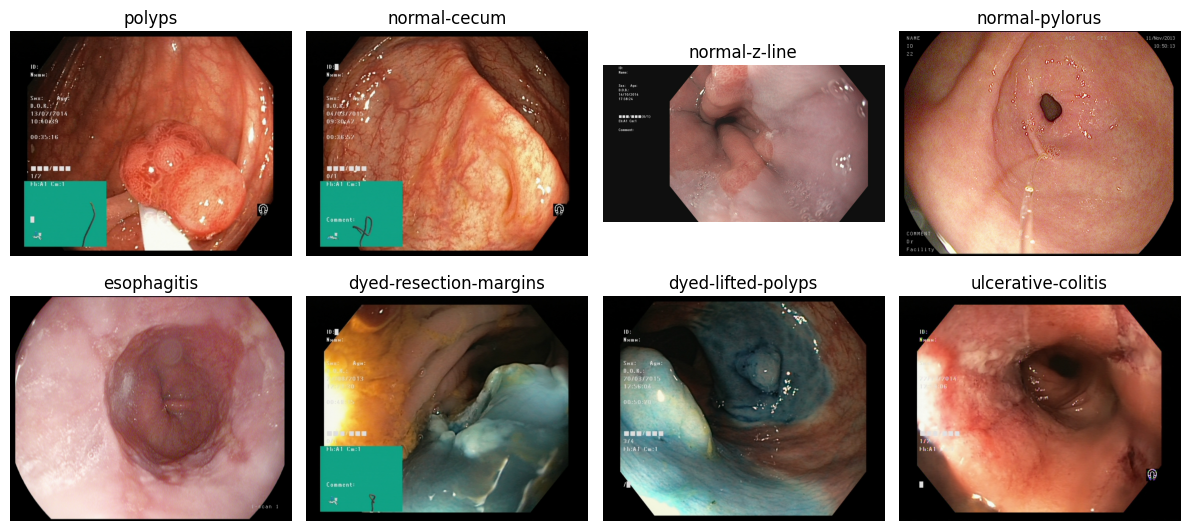

In [9]:
from matplotlib.image import imread

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Iterate through each class folder and display one image
class_folders = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

for i, class_name in enumerate(class_folders):
    class_folder = os.path.join(dataset_folder, class_name)
    image_files = os.listdir(class_folder)

    if len(image_files) > 0:
        image_path = os.path.join(class_folder, image_files[0])  # Getting the first image in each class
        img = imread(image_path)
        axes[i // 4, i % 4].imshow(img)
        axes[i // 4, i % 4].set_title(class_name)
        axes[i // 4, i % 4].axis('off')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# DataModule

In [10]:
class KvasirGIDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, seed=42):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed

    def setup(self, stage=None):
        # Define transformations for training data
        train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(degrees=(-45, 45)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Define transformations for validation and test data
        valid_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Creating the main dataset using ImageFolder
        dataset = ImageFolder(self.data_dir)

        # Split the dataset into train, validation, and test sets with fixed random seeds
        total_samples = len(dataset)
        torch.manual_seed(self.seed)
        indices = list(range(total_samples))
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        np.random.shuffle(indices)

        train_size = int(0.8 * total_samples)
        valid_size = int(0.1 * total_samples)
        test_size = total_samples - train_size - valid_size

        train_indices = indices[:train_size]
        valid_indices = indices[train_size:train_size + valid_size]
        test_indices = indices[train_size + valid_size:]

        # Create Subset classes for train, validation, and test datasets
        self.train_dataset = Subset(dataset, train_indices)
        self.valid_dataset = Subset(dataset, valid_indices)
        self.test_dataset = Subset(dataset, test_indices)

        # Apply transformations to the respective datasets
        self.train_dataset.dataset.transform = train_transforms
        self.valid_dataset.dataset.transform = valid_transforms
        self.test_dataset.dataset.transform = valid_transforms

        # Count the number of images in each class for train, validation, and test subsets
        self.train_class_counts = self.get_class_counts(self.train_dataset)
        self.valid_class_counts = self.get_class_counts(self.valid_dataset)
        self.test_class_counts = self.get_class_counts(self.test_dataset)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def get_class_counts(self, dataset):
        class_counts = {}
        for _, label in dataset:
            class_counts[label] = class_counts.get(label, 0) + 1
        return class_counts

    def print_class_counts(self):
        print("Train Subset Class Counts:")
        for class_id, count in self.train_class_counts.items():
            print(f"Class {class_id}: {count} images")

        print("\nValidation Subset Class Counts:")
        for class_id, count in self.valid_class_counts.items():
            print(f"Class {class_id}: {count} images")

        print("\nTest Subset Class Counts:")
        for class_id, count in self.test_class_counts.items():
            print(f"Class {class_id}: {count} images")


In [11]:
datamodule = KvasirGIDataModule(data_dir='/content/drive/MyDrive/Dataset/Kvasir/kvasir-dataset-v2', batch_size=32)

# Call setup to initialize class counts
datamodule.setup()

# to display the class counts
datamodule.print_class_counts()

Train Subset Class Counts:
Class 2: 793 images
Class 1: 812 images
Class 3: 793 images
Class 4: 796 images
Class 7: 792 images
Class 5: 782 images
Class 6: 817 images
Class 0: 815 images

Validation Subset Class Counts:
Class 6: 94 images
Class 7: 101 images
Class 5: 103 images
Class 1: 95 images
Class 3: 98 images
Class 4: 111 images
Class 0: 93 images
Class 2: 105 images

Test Subset Class Counts:
Class 7: 107 images
Class 2: 102 images
Class 5: 115 images
Class 6: 89 images
Class 1: 93 images
Class 3: 109 images
Class 0: 92 images
Class 4: 93 images


# Model Building

In [12]:
timm.list_models("*mobileone*")

['mobileone_s0',
 'mobileone_s1',
 'mobileone_s2',
 'mobileone_s3',
 'mobileone_s4']

In [13]:
class ImageClassifier(pl.LightningModule):

    def __init__(self, num_classes, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # Load model
        self.model = timm.create_model('mobileone_s3', pretrained=True, num_classes=num_classes)

        # Define metrics
        self.train_accuracy = Accuracy(num_classes=num_classes, task="multiclass")
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.top3_accuracy = Accuracy(task="multiclass", num_classes=num_classes, top_k=3)
        self.top5_accuracy = Accuracy(task="multiclass", num_classes=num_classes, top_k=5)
        self.f1 = F1Score(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log('train_loss', loss, prog_bar=True, logger=True, )
        self.log('train_acc', self.train_accuracy(logits.softmax(dim=-1), y), prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_acc', self.val_accuracy(logits.softmax(dim=-1), y), prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log('test_acc', self.test_accuracy(logits.softmax(dim=-1), y), prog_bar=True)
        self.log('top3_acc', self.top3_accuracy(logits.softmax(dim=-1), y), prog_bar=True)
        self.log('top5_acc', self.top5_accuracy(logits.softmax(dim=-1), y), prog_bar=True)
        self.log('f1', self.f1(logits.softmax(dim=-1), y), prog_bar=True)
        self.confusion_matrix(logits.softmax(dim=-1), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import  WandbLogger


# Initializing data module
datamodule = KvasirGIDataModule(data_dir='/content/drive/MyDrive/Dataset/Kvasir/kvasir-dataset-v2', batch_size=32)

# Initializing the ImageClassifier model
model = ImageClassifier(num_classes=8, learning_rate=1e-3)

# Initialize wandb logger
wandb_logger = WandbLogger(project='kvasir_GI', name='mobileOne_s3_run1', job_type='train', save_dir="/content/drive/MyDrive/Dataset/Kvasir/Logs")

# ModelCheckpoint callback to save models during training
checkpoint_callback = ModelCheckpoint(
    dirpath='/content/drive/MyDrive/Dataset/Kvasir/Model_checkpoint',
    filename='mobileOne_s3-{epoch:02d}-{val_acc:.4f}',
    monitor='val_acc',
    mode='max',
    save_top_k=-1  # to save all models; if set to k , top k models will be saved
)

# Initializing the Trainer
trainer = pl.Trainer(
    accelerator="gpu",        # "cpu", "gpu", "tpu", "ipu", "auto"
    max_epochs=12,             # the number of epochs
    precision="16-mixed",
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

# Train the model
trainer.fit(model, datamodule)

# Close wandb run
wandb.finish()

wandb: Currently logged in as: rifat004. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Dataset/Kvasir/Model_checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | model            | ByobNet                   | 8

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_acc,▂▁▁▅▇▇▆▇▅▅▆█▆▇▅▆██▂▇█▇█▆▇▂▇█▆█▆▇▅▇▇█▅▇█▇
train_loss,▅▇▇█▃▂▃▃▅▅▃▁▃▃▄▆▁▁▆▃▁▂▂▃▂▅▃▁▂▁▇▂▄▂▂▁▅▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▂▃█▅▇▅▅▃▄▇
val_loss,▂▃▅▃▁▃▂▄▃█▅▂
epoch,11
train_acc,0.96875
train_loss,0.05966
trainer/global_step,2399
val_acc,0.8975


# Test

In [ ]:
checkpoint_callback.best_model_path

'/content/drive/MyDrive/Dataset/Kvasir/Model_checkpoint/mobileOne_s3-epoch=04-val_acc=0.9075-v1.ckpt'

wandb: Currently logged in as: rifat004. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Test test_acc: 0.9162
Test top3_acc: 0.9975
Test top5_acc: 1.0000
Test f1: 0.9162


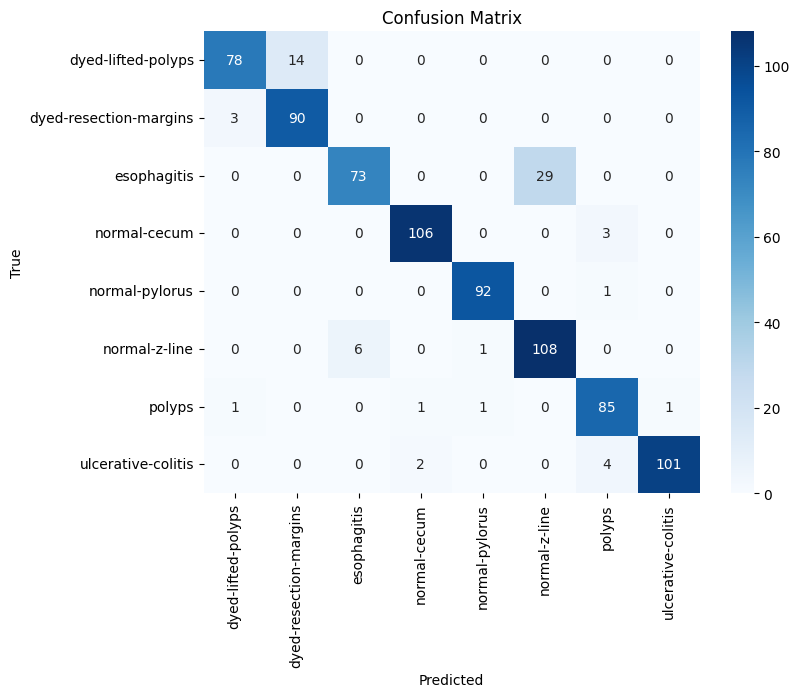

epoch,▁
f1,▁
test_acc,▁
top3_acc,▁
top5_acc,▁
trainer/global_step,▁
epoch,0
f1,0.91625
test_acc,0.91625
top3_acc,0.9975
top5_acc,1.0


In [14]:
# Test the model with the highest validation accuracy
best_model = ImageClassifier.load_from_checkpoint('/content/drive/MyDrive/Dataset/Kvasir/Model_checkpoint/mobileOne_s3-epoch=04-val_acc=0.9075-v1.ckpt')

test_metrics = ['test_acc', 'top3_acc', 'top5_acc', 'f1']

# starting new wandblogger for testing, as i called finish for previous wandb run
wandb_logger_test = WandbLogger(project='kvasir_GI', name='mobileOne_s3_test_run1', job_type='test', save_dir="/content/drive/MyDrive/Dataset/Kvasir/Logs")

trainer = pl.Trainer(
    accelerator="gpu",
    precision="16-mixed",
    logger=wandb_logger_test,
)

# Test the best model on the test dataset
result = trainer.test(best_model, datamodule=datamodule, verbose=False)
for metric in test_metrics:
    print(f"Test {metric}: {result[0][metric]:.4f}")

# Retrieve class names and plot the confusion matrix heatmap
class_names = datamodule.test_dataset.dataset.classes

confusion_matrix = best_model.confusion_matrix.compute().numpy()
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Close wandb run
wandb.finish()

# Kvasir GI image classification using MobileOne architecture in PyTorch lightning framework

This repository contains code for the Kvasir Gastrointestinal (GI) tract image classification task. The goal is to get familiarized with Lightning framework and mobileOne architecture.

## Workflow

**1. Dataset details:** The Kvasir dataset consists of images, annotated and verified by medical doctors (experienced endoscopists), including several classes showing anatomical landmarks, phatological findings or endoscopic procedures in the GI tract. The anatomical landmarks include Z-line, pylorus, and cecum, while the pathological finding includes esophagitis, polyps, and ulcerative colitis. In addition, there are another two class images related to removal of lesions, "dyed and lifted polyp" and the "dyed resection margins". The dataset consist of the images with different resolution from 720x576 up to 1920x1072 pixels and organized in a way where they are sorted in separate folders named accordingly to the content. Some of the included classes of images have a green picture in picture illustrating the position and configuration of the endoscope inside the bowel, by use of an electromagnetic imaging system (ScopeGuide, Olympus Europe) that may support the interpretation of the image.

**2. Loading the dataset:** I have unzipped the data from my google drive as I have stored the zip file (kvasir-v2.zip) in my google drive. In the data folder, each subfolder represents each class.

**3. EDA:**: To check the class distribution, I counted the number of images in each class within the Kvasir GI dataset. I found that there are 8 Classes and there are 1000 images for each of the clas. I showed that by plotting a bar chart. I have also displayed sample images from each class in a grid. The classes are the following:

- dyed-lifted-polyps
- dyed-resection-margins
- esophagitis
- normal-cecum
- normal-pylorus
- normal-z-line
- polyps
- ulcerative-colitis

**4. Creating Data Module:**: I have created the data module class which is responsible for managing the Kvasir GI dataset, including preprocessing and splitting into training, validation, and test sets. I initialized the data module by specifying essential parameters such as the data directory, batch size, and random seed. Then I defined a set of data transformations for the training dataset, including resizing images, random rotations, flips, color jittering, converting to tensors, and normalization. For the validation and test datasets, I defined a separate set of transformations, which includes resizing, converting to tensors, and normalization. These transformations ensure that the validation and test data are prepared consistently. I split the Kvasir GI dataset into training, validation, and test subsets while maintaining a fixed random seed for reproducibility. I have taken 80% of the total samples(8000)for training, 10% for validation, and 10% for testing. I have applied the defined data transformations to the respective subsets. I have created dataloader for training, validation, and test. I have also defined method to calculate and store the number of images in each class for the training, validation, and test subsets.

**5. Model Building:** I have constructed image classification model within the PyTorch Lightning Module called ImageClassifier. This module is responsible for defining the model architecture, specifying metrics, and handling training and evaluation steps. I initialized the model by selecting the MobileOne architecture with s3 and s4 variant from the timm library. The forward method in the ImageClassifier module is where I defined the forward pass of the model. Given an input image, the forward pass computes the model's predictions (logits) for each class. These logits will later be used to compute the loss and evaluate the model's performance.

In the training_step method, I specified the logic for a single training step.
This includes passing a batch of training data through the model, computing the loss (cross-entropy), and logging training-related metrics. Metrics logged during training include training loss and training accuracy. Within the validation_step method,the validation loss and validation accuracy are computed and logged. In test_step, the model's performance is evaluated on a held-out test dataset. Test loss, test accuracy, top-k accuracy, and F1 score are computed and logged. I configured the optimizer used for training, typically using an Adam optimizer. The learning rate is set based on the specified hyperparameters. The speed of training was also fast with these models on colab GPU.

**6. Model training,validation and WandB integration:** After initializing datamodule and classification model using the ImageClassifier class, I initialize Wandb logger. I configured a model checkpoint callback named checkpoint_callback to save models during training. Then, I initialized a PyTorch Lightning trainer named trainer for training and evaluation. The accelerator is set to "gpu" to leverage GPU acceleration if available.
I enabled mixed-precision training by setting the precision to "16-mixed". This speeds up training and Reduces GPU Memory Usage. Then I used trainer.fit to train the model for the specified number of epochs. The trained model will be saved based on the best validation accuracy achieved during training.

**7. Model Evaluation on test data:** Then I used trainer.test on test data and returned accuracy, Top 3 Accuracy, Top 5 accuracy, F1 score. I also plotted the confusion matrix.

**8. Result:**

| Model        | Accuracy | Top 3 Accuracy | Top 5 Accuracy | F1 score |
| ------------ | -------- | -------------- | -------------- | -------- |
| mobileone_s3 | 91.625%   | 99.75%         | 100%         | 0.91625   |
| mobileone_s4 | 91.875%  | 99.875%        | 100%        | 0.91875  |

## Conclusion:

This project demonstrates the entire workflow of building a deep learning model in PyTorch Lightning framework. The achieved accuracy on the testing dataset reflects the models capability to generalize and classify images accurately. I have compared accuracy of two variants of mobileOne model (s3 and s4). Among the models, mobileone_s4 achieved slighlty more accuracy than s3 variant. But, s3 variant has less parameters. So, it is more memory efficient.

Note: MobileOne_s4 is used in another notebook.
